# SST: Analysis for Item Test

###Procedure

**Session 1**: 

1. Watch 4 videos of each town (2/town in a row)
2. <span style="color:red"> Item test (run 1)</span>
3. Navigation with arrows (2/town)
4. <span style="color:red">Item test (run 2)</span>

**Session 2**:

1. Watch 1 video of each town (2 for subjects 1-4)
2. <span style="color:red">Item test (run 3)</span>
3. Navigation with arrows (2/town)
4. Free navigation without arrows (2/town)
5. <span style="color:red">Item test (run 4)</span>

**Session 3**:

1. Test trials, navigate to item in each environment (2 cycles)
2. Questionnaire about strategies used, etc.
3. <span style="color:red">Item test (run 5)</span>
4. Map drawing
5. Spatial preference questionnaire

### Item test: 
Present subjects with image from town, and asked to recall the 3 items located within that town and to type the names of the items. If they didn't remember an item, they responded with a "?".


Sample image from town:

![env3](./images/env3.jpg)


## Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op
import numpy as np

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

Loading required package: lme4
Loading required package: Matrix
Loading required package: Rcpp


Loading required package: lmerTest

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



### Define color palette

In [2]:
palette = {'face': 'orange',
           'animal': 'dodgerblue',
           'object': 'lightseagreen',
           'food':  'mediumseagreen',
           'tool': 'mediumpurple'}

## Setup paths

In [3]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['object_cat_file'] = op.join(dirs['datadir'], 'object_cat.csv')

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)

subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN
4,5,pilot,0,NaN
5,6,pilot,0,NaN
6,7,pilot,0,NaN
7,8,pilot,0,NaN


In [5]:
#Load in file w/object sub-categories for each town, convert to dict
obj_cat = pd.read_csv(dirs['object_cat_file'])
obj_cat = obj_cat.set_index('town').to_dict()['object_cat']

## Load in data

In [6]:
dt = pd.DataFrame() 
test = True
questionnaires_post = True

for subid in subj_info.subid:
    print subid

    if test:
        # add test file
        test_file = op.join(dirs['datadir'], subid, subid + '_behav_itemTest_coded.csv')
        d2 = pd.read_csv(test_file)
        d2['subid'] = subid
        dt = dt.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

1
2
3
4
5
6
7
8


In [7]:
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid
0,7,1,3,39.8986,19.2681,Town1,env1.jpg,1,zebra,6.7555,animal,1,1
1,8,1,3,39.8986,19.2681,Town1,env1.jpg,2,george clooney,5.7986,face,1,1
2,9,1,3,39.8986,19.2681,Town1,env1.jpg,3,Lettuce,6.7118,object,1,1
3,52,2,6,89.7360,8.8618,Town1,env1.jpg,1,zebra,3.0541,animal,1,1
4,53,2,6,89.7360,8.8618,Town1,env1.jpg,2,george clooney,3.5342,face,1,1


#### Add in sub-type for objects

In [8]:
dt['itemType_sub'] = dt.itemType
dt.ix[dt.itemType == 'object', 'itemType_sub'] = dt[dt.itemType == 'object'].town.map(obj_cat.get)
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid,itemType_sub
0,7,1,3,39.8986,19.2681,Town1,env1.jpg,1,zebra,6.7555,animal,1,1,animal
1,8,1,3,39.8986,19.2681,Town1,env1.jpg,2,george clooney,5.7986,face,1,1,face
2,9,1,3,39.8986,19.2681,Town1,env1.jpg,3,Lettuce,6.7118,object,1,1,food
3,52,2,6,89.7360,8.8618,Town1,env1.jpg,1,zebra,3.0541,animal,1,1,animal
4,53,2,6,89.7360,8.8618,Town1,env1.jpg,2,george clooney,3.5342,face,1,1,face


In [9]:
dq_post.head()

,subid,compass,generalSOD,landmark,route,survey,surveySpatial,verbalSpatial,survey_pref
0,1,6,11,10,8,6,5,3,-4
1,2,5,12,10,8,5,4,2,-5
2,3,5,15,8,8,4,2,5,-4
3,4,7,16,9,8,7,4,3,-2
4,5,5,10,8,2,2,5,1,-6


## Analysis

(0, 1)

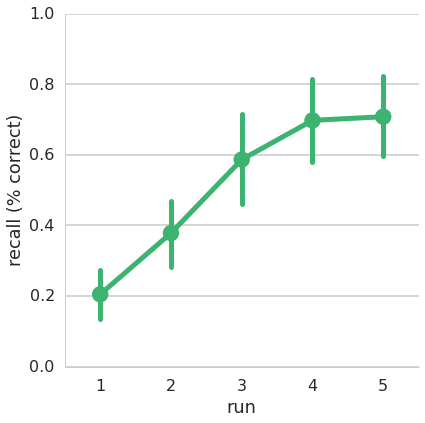

In [27]:
data = dt.groupby(['subid', 'run']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.2,
               units='subid', ci=68, data=data,
               color='mediumseagreen', size=6)
plt.ylim(0,1)

(-0.1, 1.1)

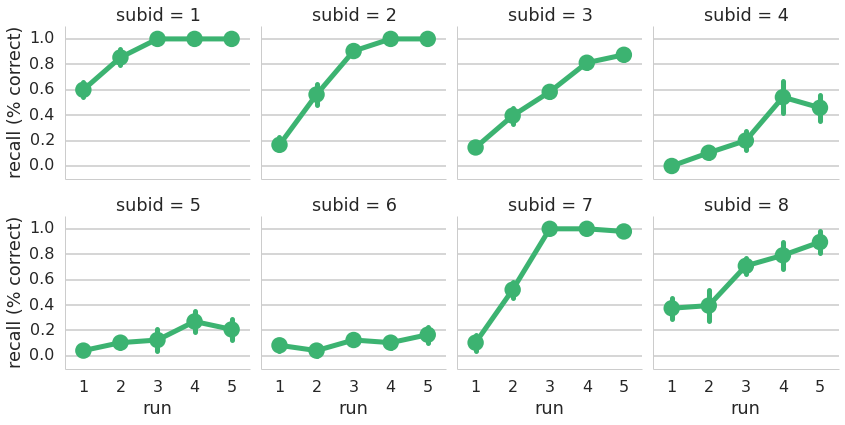

In [30]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.1, ci=68,
               col='subid', col_wrap=4, data=data,
               color='mediumseagreen', size=3)
plt.ylim(-.1,1.1)

### Accuracy across runs, by type of item

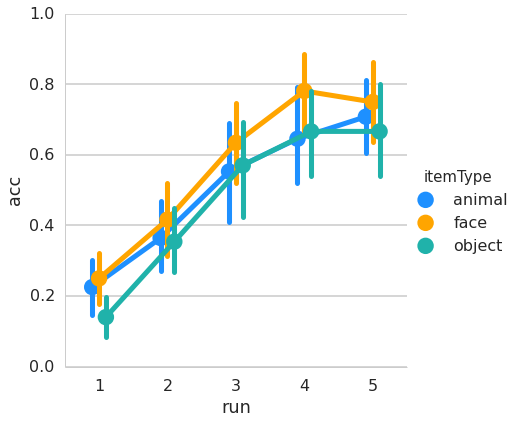

In [83]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette, size=6)

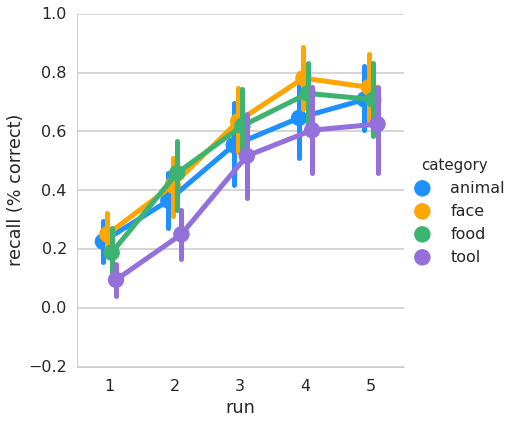

In [84]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['category'] = data.itemType_sub
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', hue='category',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette, size=6)
# plt.title()

#### Mean accuracy and standard error for final training (4th) run

In [85]:
data = dt[dt.run == 4].groupby(['itemType_sub']).mean().reset_index()[['itemType_sub', 'acc']]
data['st.err'] = dt[dt.run == 4].groupby(['itemType_sub']).std().reset_index()[['acc']]/subj_info.subid.size
data

,itemType_sub,acc,st.err
0,animal,0.645833,0.060096
1,face,0.781250,0.051946
2,food,0.729167,0.056137
3,tool,0.604167,0.061775


In [86]:
data = dt[dt.run == 4].groupby('subid').mean().reset_index()
data.describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,8.0,8,8.0,8.000000,8.000000,8,8.000000,8.000000
mean,126.5,4,6.5,75.380258,13.387160,2,4.461701,0.697917
std,0.0,0,0.0,25.996541,4.226907,0,1.408963,0.349615
min,126.5,4,6.5,54.453283,10.160808,2,3.386250,0.083333
25%,126.5,4,6.5,55.106292,10.623419,2,3.540462,0.493056
50%,126.5,4,6.5,71.098208,11.565196,2,3.854388,0.819444
75%,126.5,4,6.5,80.465429,14.820456,2,4.939458,1.000000
max,126.5,4,6.5,133.154300,22.665283,2,7.554397,1.000000


#### Broken down by subject

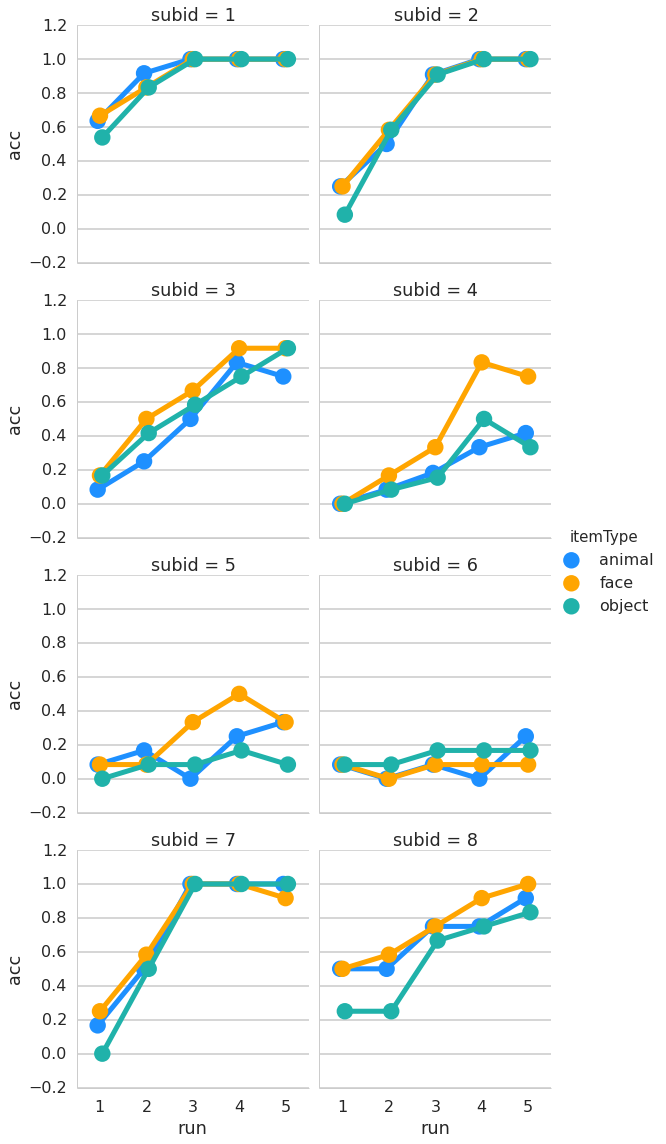

In [87]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               col='subid', col_wrap=2, data=data,
               palette=palette)

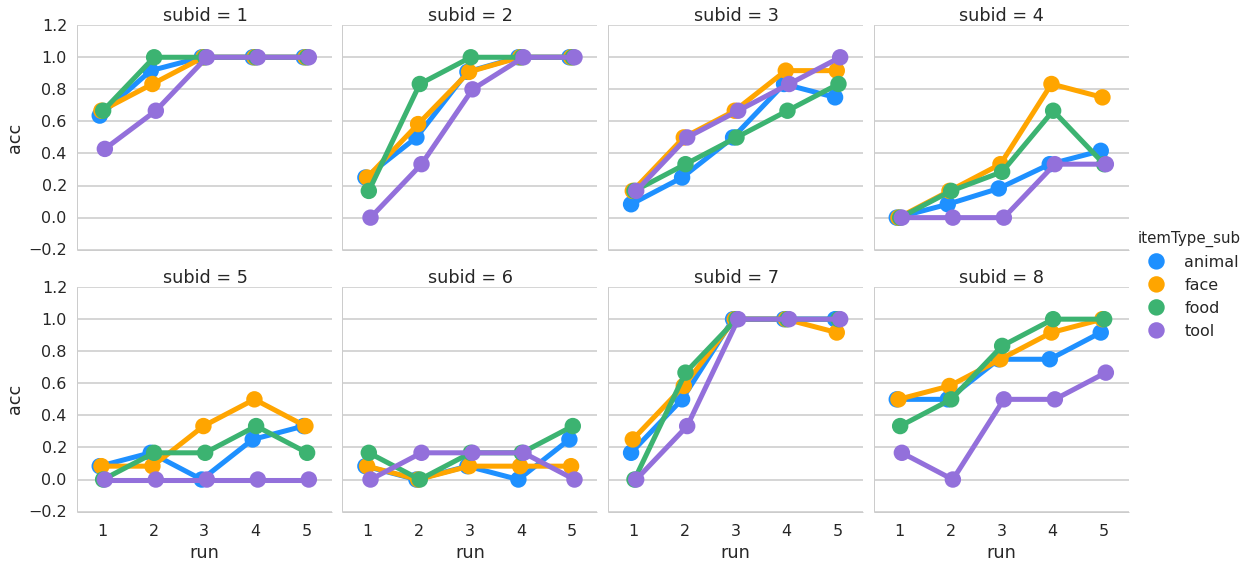

In [106]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType_sub',
               dodge=.1,
               col='subid', col_wrap=4, data=data,
               palette=palette)

### Final training accuracy for item types

In [112]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data[data.subid.isin(['1', '2', '3', '4', '7', '8'])].describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,6.0,6,6.0,6.000000,6.000000,6,6.000000,6.000000
mean,126.5,4,6.5,66.354114,12.122453,2,4.040133,0.865741
std,0.0,0,0.0,13.349078,2.303521,0,0.767835,0.176048
min,126.5,4,6.5,54.453283,10.160808,2,3.386250,0.555556
25%,126.5,4,6.5,54.923542,10.467323,2,3.488424,0.812500
50%,126.5,4,6.5,62.815500,11.067287,2,3.688421,0.916667
75%,126.5,4,6.5,77.103390,13.820190,2,4.606040,1.000000
max,126.5,4,6.5,83.881492,15.434175,2,5.144033,1.000000


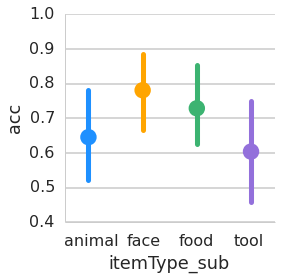

In [89]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', hue='itemType_sub',
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

### How does final training accuracy relate to spatial preference?

In [113]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')

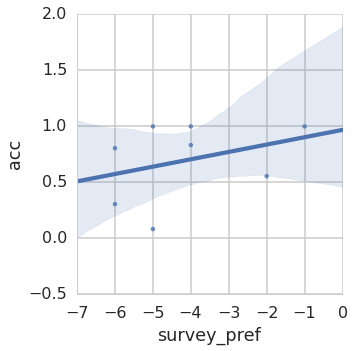

In [91]:
sns.lmplot(x='survey_pref', y='acc', 
           data=data)

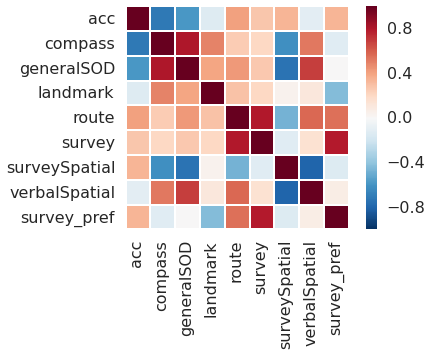

In [92]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')
dsub = data.ix[:,8:].T
sns.heatmap(np.corrcoef(dsub), 
            xticklabels=dsub.index,
            yticklabels=dsub.index,
            square=True)

#### Statistical difference between acc for different item types?

In [93]:
data = dt[dt.run == 4].groupby(['itemType_sub', 'subid', 'town']).mean().reset_index()[['subid', 'itemType_sub', 'acc', 'town']]
%R -i data

In [94]:
%%R

res1 = lmer(acc ~ itemType_sub + (1 | subid) + (1 | town), data=data)
res2 = lmer(acc ~ itemType_sub + (1 | subid), data=data)
print(anova(res2, res1, refit=FALSE))

print(summary(res1))

Data: data
Models:
object: acc ~ itemType_sub + (1 | subid)
..1: acc ~ itemType_sub + (1 | subid) + (1 | town)
       Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)  
object  6 215.47 237.45 -101.74   203.47                          
..1     7 214.38 240.03 -100.19   200.38 3.089      1    0.07882 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['merModLmerTest']
Formula: acc ~ itemType_sub + (1 | subid) + (1 | town)
   Data: data

REML criterion at convergence: 200.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.88255 -0.41572  0.09147  0.43630  3.14387 

Random effects:
 Groups   Name        Variance Std.Dev.
 town     (Intercept) 0.004242 0.06513 
 subid    (Intercept) 0.119479 0.34566 
 Residual             0.099069 0.31475 
Number of obs: 288, groups:  town, 12; subid, 8

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)        0.64583    0.12775   7.

### Final training (run 4) accuracy across environments

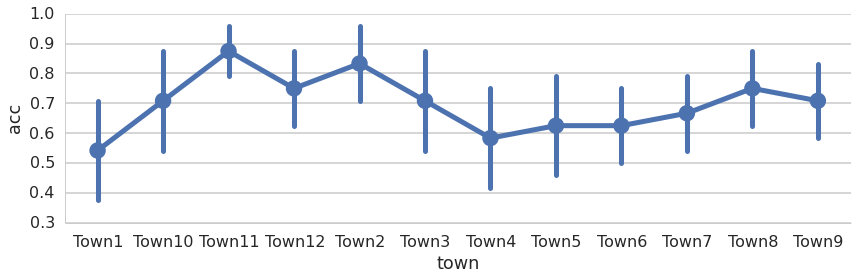

In [95]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

#### Broken down by item type for each town

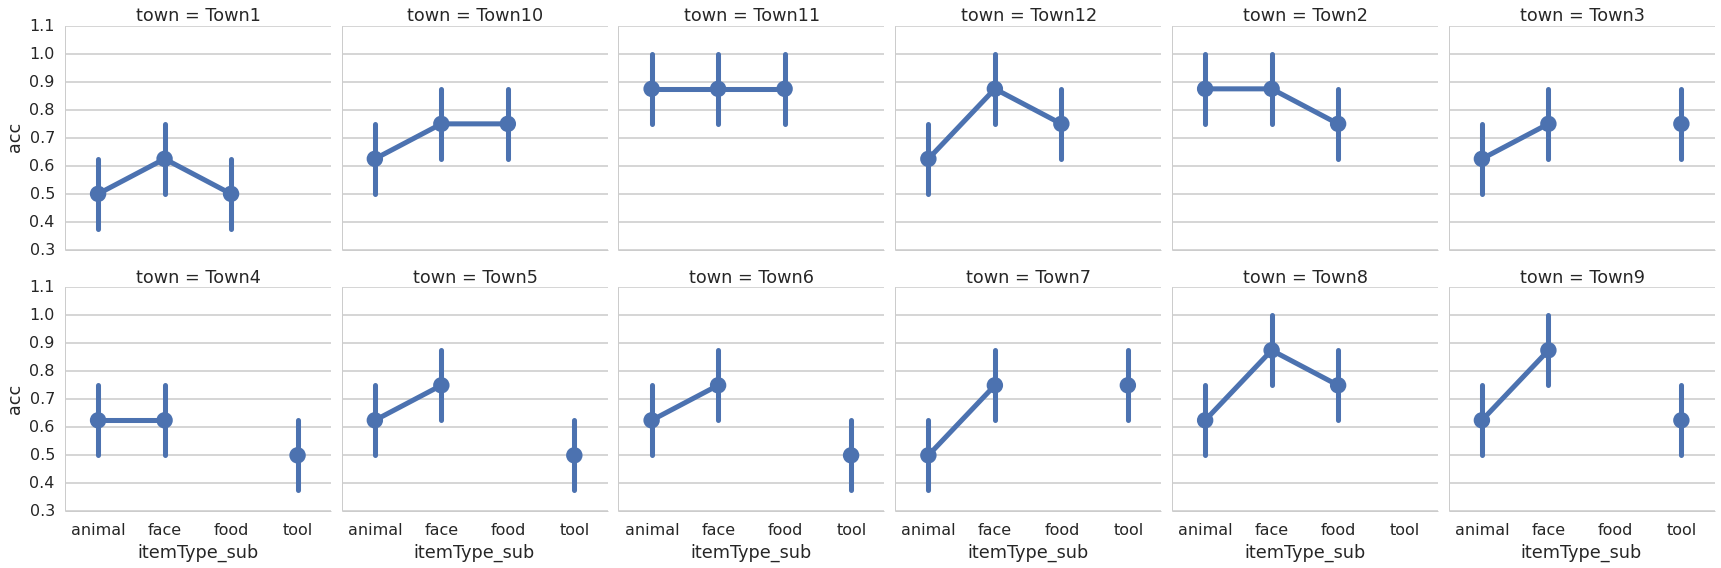

In [96]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', col='town', col_wrap=6,
               dodge=0, aspect=1, 
               units='subid', ci=68, data=data)

### Order of recalling items

#### Correct recall, run 4

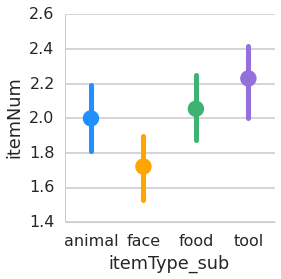

In [122]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

In [123]:
%R -i data

In [131]:
%%R 
print(str(data))
df <- within(data, itemType_sub <- relevel(itemType_sub, ref =2))
print(summary(lmer(itemNum ~ itemType_sub + (1 | subid), data=df)))

'data.frame':	70 obs. of  10 variables:
 $ subid       : Factor w/ 8 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ itemNum     : int [1:70(1d)] 1 1 2 2 2 2 3 3 3 1 ...
 $ itemType_sub: Factor w/ 4 levels "animal","face",..: 1 2 1 2 3 4 1 3 4 1 ...
 $ index       : num [1:70(1d)] 129 124 121 130 134 ...
 $ run         : num [1:70(1d)] 4 4 4 4 4 4 4 4 4 4 ...
 $ trial       : num [1:70(1d)] 7.67 6.11 4.6 7.67 9 ...
 $ onset       : num [1:70(1d)] 68.3 50.8 36.1 68.3 80 ...
 $ duration    : num [1:70(1d)] 9.42 10.41 9.96 9.42 9.95 ...
 $ respRT      : num [1:70(1d)] 2.02 5.13 2.36 4.71 4.32 ...
 $ acc         : num [1:70(1d)] 1 1 1 1 1 1 1 1 1 1 ...
NULL
Linear mixed model fit by REML ['merModLmerTest']
Formula: itemNum ~ itemType_sub + (1 | subid)
   Data: df

REML criterion at convergence: 167

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5642 -0.9179 -0.0353  0.9776  1.6239 

Random effects:
 Groups   Name        Variance Std.Dev.
 subid    (Intercept) 0.0000 

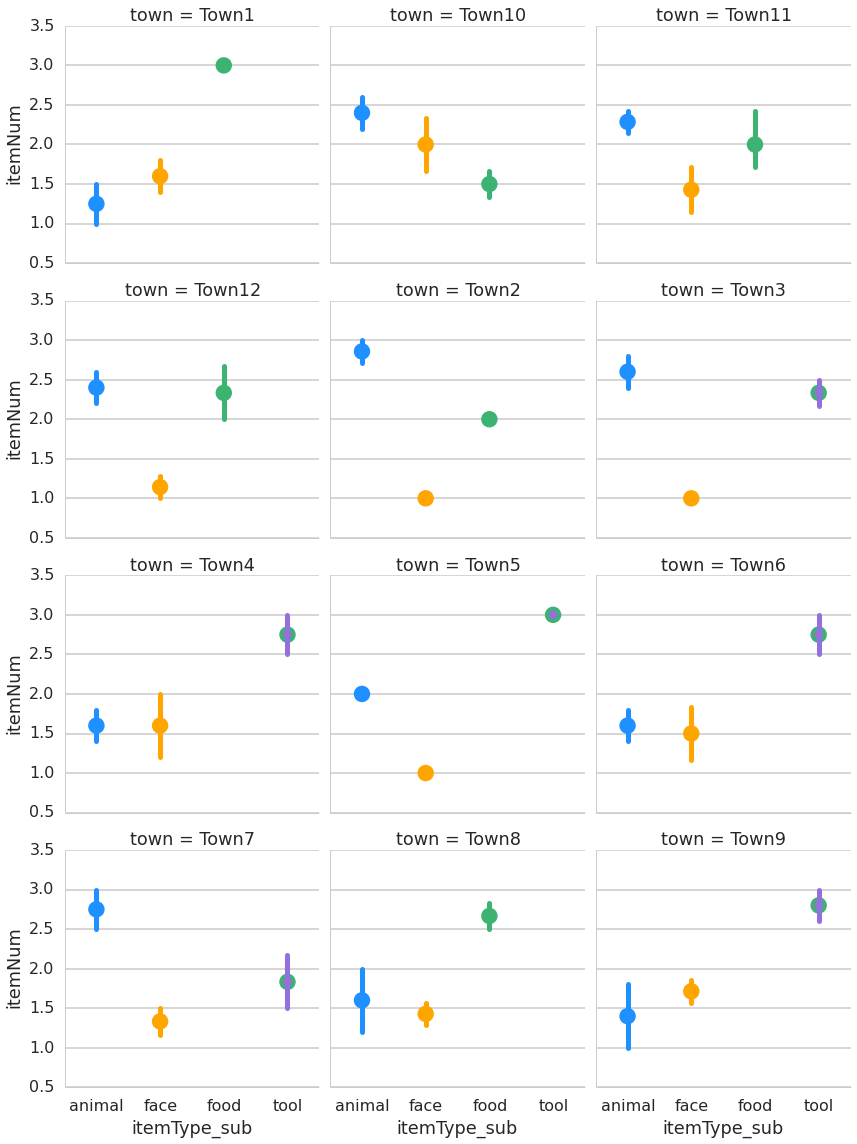

In [98]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'town', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1, col='town', col_wrap=3,
               units='subid', ci=68, data=data, palette=palette)

#### Correct recall, across runs

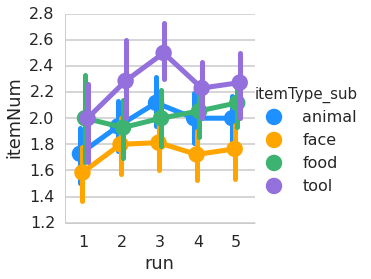

In [99]:
data = dt[(dt.acc == 1)].groupby(['subid', 'itemNum', 'itemType_sub', 'run']).mean().reset_index()
sns.factorplot(x='run', y='itemNum', hue='itemType_sub',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette)

## RTs for correct responses

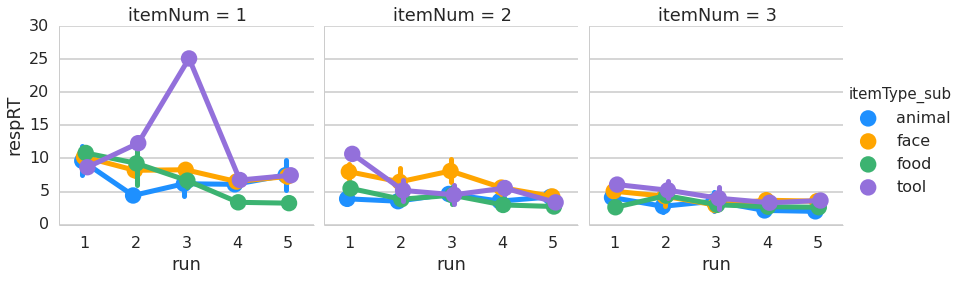

In [100]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub', 'itemNum']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               col='itemNum',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)

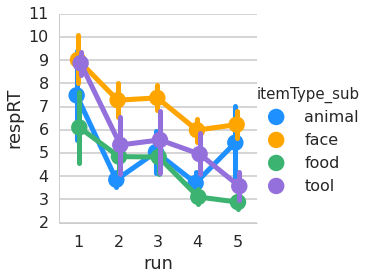

In [101]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)